In [2]:
! pip install MTCNN

     |████████████████████████████████| 2.3 MB 848 kB/s eta 0:00:01


The code below will input the image.  Then it detects the face or faces in the image.
It then selects the largest face (most pixels in it) and detects the centers of the
left and right eye. It then determines the angle of the line joining the eye centers.
This angle is then feed into a function that rotates the image so the line is paralllel
to the x axis. Then the rotatedimage is cropped to return the largest face and the image
is stored in the working/dir/car.
MTCNN is the most acurate face cropper I have found but unfortunately it is very slow.
Consequently I only tried to crop and align 10 images. I did not bother with the sementation
task.


In [3]:
import tensorflow
from mtcnn import MTCNN
import cv2
import os
import numpy as np
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [4]:
def align(img):
    # This function takes in an image, detects the bounding boxes for the face or faces
    # in the image and then selects the face with the largest number of pixels.
    # for the largest face the eye centers are detected and the angle of the eyes with respect to
    # the horizontal axis is determined. It then provides this angle to the rotate_bound function
    # the rotate_bound function the rotates the image so the eyes are parallel to the horizontal axis
        
    data=detector.detect_faces(img)
    # In case the image has more than 1 face, find the biggest face
    biggest=0
    if data !=[]:
        for faces in data:
            box=faces['box']            
            # calculate the area in the image
            area = box[3]  * box[2]
            if area>biggest:
                biggest=area
                bbox=box                
                keypoints=faces['keypoints']
                left_eye=keypoints['left_eye']
                right_eye=keypoints['right_eye']                 
        lx,ly=left_eye        
        rx,ry=right_eye
        dx=rx-lx
        dy=ry-ly
        tan=dy/dx
        theta=np.arctan(tan)
        theta=np.degrees(theta)    
        img=rotate_bound(img, theta)        
        return (True,img)
    else:
        return (False, None)
 

In [5]:
def crop_image(img): 
    data=detector.detect_faces(img)
    #y=box[1] h=box[3] x=box[0] w=box[2]   
    biggest=0
    if data !=[]:
        for faces in data:
            box=faces['box']            
            # calculate the area in the image
            area = box[3]  * box[2]
            if area>biggest:
                biggest=area
                bbox=box 
        bbox[0]= 0 if bbox[0]<0 else bbox[0]
        bbox[1]= 0 if bbox[1]<0 else bbox[1]
        img=img[bbox[1]: bbox[1]+bbox[3],bbox[0]: bbox[0]+ bbox[2]]        
        return (True, img) 
    else:
        return (False, None)
    
def rotate_bound(image, angle):
    #rotates an image by the degree angle
    # grab the dimensions of the image and then determine the center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1]) 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin)) 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH)) 

In [6]:
def align_crop_resize(sdir,dest_dir, height=None, width= None): 
    aligned_dir=os.path.join(dest_dir, 'Aligned Images')
    cropped_dir=os.path.join(dest_dir, 'Cropped_Images')
    if os.path.isdir(dest_dir):
        shutil.rmtree(dest_dir)
    os.mkdir(dest_dir)  #start with an empty destination directory
    os.mkdir(aligned_dir)
    os.mkdir(cropped_dir)
    flist=os.listdir(sdir) #get a list of the image files    
    success_count=0
    for i,f in enumerate(flist): # iterate through the image files
        fpath=os.path.join(sdir,f)        
        if os.path.isfile(fpath) and i <10:
            try:
                img=cv2.imread(fpath) # read in the image
                shape=img.shape
                status,img=align(img) # rotates the image for the eyes are horizontal
                if status:
                    aligned_path=os.path.join(aligned_dir,f)
                    cv2.imwrite(aligned_path, img)                    
                    cstatus, img=crop_image(img) # crops the aligned image to return the largest face
                    if cstatus:
                        if height != None and width !=None:
                            img=cv2.resize(img, (height, width)) # if height annd width are specified resize the image
                        cropped_path=os.path.join(cropped_dir, f)
                        cv2.imwrite(cropped_path, img) # save the image
                        success_count +=1 # update the coount of successful processed images
                
            except:
                print('file ', fpath, ' is a bad image file')
    return success_count
   

In [7]:
detector = MTCNN()
sdir=r'../input/ffhq-flickr-faces-align-crop-and-segment'
working_dir=r'./'
dest_dir=os.path.join(working_dir, 'results')
height=128
width=128
count=align_crop_resize(sdir,dest_dir)
print ('Number of sucessfully processed images= ', count)

Number of sucessful processed images=  9


define a function to show images

In [8]:
def show_images(tdir):
    filelist=os.listdir(tdir)
    length=len(filelist)
    columns=5
    rows=int(np.ceil(length/columns))    
    plt.figure(figsize=(20, rows * 4))
    for i, f in enumerate(filelist):    
        fpath=os.path.join(tdir, f)
        imgpath=os.path.join(tdir,f)
        img=plt.imread(imgpath)
        plt.subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title(f, color='blue', fontsize=12)
        plt.imshow(img)

show the cropped images

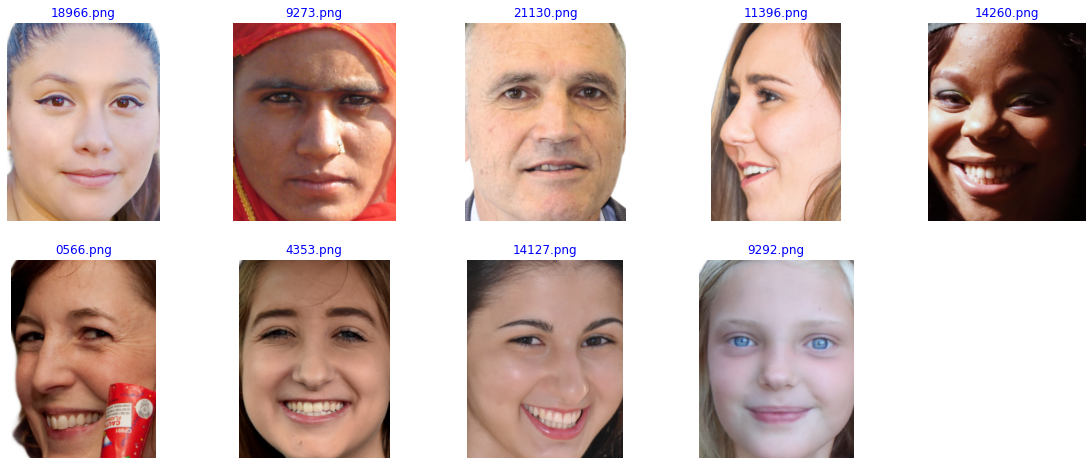

In [9]:
show_dir=os.path.join(dest_dir, 'Cropped_Images')
show_images(show_dir)

show the aligned images before being cropped

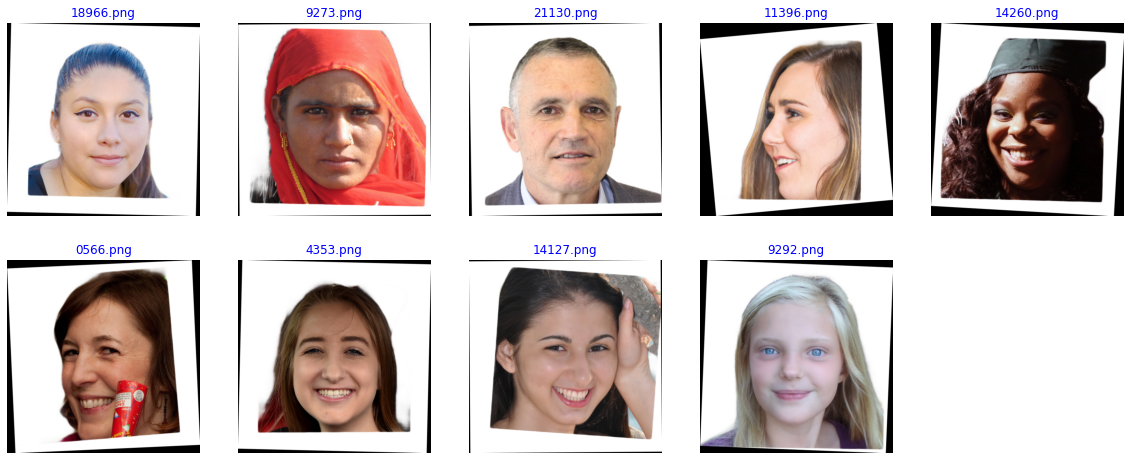

In [10]:
show_dir=os.path.join(dest_dir, 'Aligned Images')
show_images(show_dir)